## Wisconsin Breast Cancer Dataset
### *Darren Tanner*

This dataset includes information from breast cell biopsies, including whether or not the cells biopsied were diagnosed as indicating malignant tumors or not. The data include the sample ID number, 9 relevant features from the biopsies, and a column indicating whether or not the sample was malignant or benign.

The goal of the analyses below is to build a model that can accurately classify a sample as malignant or benign, based on the other features of the sample.

The resulting model was highly accurate, with a mean recall rate of .98 and a mean precision of .98, with an F1 score of .98. This indicates that the model was highly accurate in discriminating between malignant and benign samples.

The most important feature in determining malignancy was uniformity of shape, followed closely by uniformity of size and bare nuclei. Malignant tumors have higher values for these features and more variable values than benign tumors.

## Import packages and data

In [2]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import seaborn as sns
%matplotlib inline

Let's now import the data, give the columns names, and recode the outcome variable to more meaningful values, and look at the first few rows of data.

In [3]:
data = pd.read_csv("breast_cancer.csv", header = None)
data.columns = ['sample_id', 'clump_thickness', 'uniformity_size', 'uniformity_shape',
                'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei', 'bland_chromatin',
                'normal_nucleoli', 'mitoses', 'malignant']

# Recode the 'malignant' variable to 0 (benign) and 1 (malignant)
data['malignant'] = np.where(data.malignant == 2, 0, 1)

data.head()

,sample_id,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


### Exploratory analysis

In [4]:
data.describe()

,sample_id,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epithelial_size,bland_chromatin,normal_nucleoli,mitoses,malignant
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [5]:
data.shape

(699, 11)

There are 699 observations, with 9 predictor variables and 1 outcome variable (malignant) and the ID variable.

In [6]:
# Check for missing values
data.isnull().sum()  # None

sample_id                 0
clump_thickness           0
uniformity_size           0
uniformity_shape          0
marginal_adhesion         0
single_epithelial_size    0
bare_nuclei               0
bland_chromatin           0
normal_nucleoli           0
mitoses                   0
malignant                 0
dtype: int64

In [7]:
data.dtypes

sample_id                  int64
clump_thickness            int64
uniformity_size            int64
uniformity_shape           int64
marginal_adhesion          int64
single_epithelial_size     int64
bare_nuclei               object
bland_chromatin            int64
normal_nucleoli            int64
mitoses                    int64
malignant                  int64
dtype: object

The fact that bare_nuclei is listed as an object (i.e., string) means that not all of the values are numbers. I would suspect that this means that there are characters in this column that are likely to indicate missing values.

Let's investigate more.

In [8]:
data.bare_nuclei.unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

The '?' valule of bare_nuclei seems likely to me to indicate missing data. Keep this in mind for shortly -- this will be investigated further in a bit.

First, I need to identify the distribution/frequency of malignant versus benign observations.

In [9]:
outcomes = data.malignant.value_counts()
outcomes

0    458
1    241
Name: malignant, dtype: int64

241 of the 699 observations are malignant. There are almost twice as many benign observations as malignant observations. Since the outcome variable is unbalanced, this will need to be considered when splitting the data into test and training sets, and weighting might need to be considered when modeling the data.

In [10]:
outcomes[[1]]/np.sum(outcomes) # .344 (about 1/3) of observations are malignant

1    0.344778
Name: malignant, dtype: float64

#### Understanding the missing data

Now back to bare_nuclei to see how many '?' entries there are, see what their properties are and if there is systematicity to what data are missing, and then impute values for them.

In [11]:
data.bare_nuclei.value_counts()  # 16 missing values

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [12]:
# What do the missing data look like?
missing = data[data.bare_nuclei == '?']
missing # Mostly benign, but not exclusively

,sample_id,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
23,1057013,8,4,5,1,2,?,7,3,1,1
40,1096800,6,6,6,9,6,?,7,8,1,0
139,1183246,1,1,1,1,1,?,2,1,1,0
145,1184840,1,1,3,1,2,?,2,1,1,0
158,1193683,1,1,2,1,3,?,1,1,1,0
164,1197510,5,1,1,1,2,?,3,1,1,0
235,1241232,3,1,4,1,2,?,3,1,1,0
249,169356,3,1,1,1,2,?,3,1,1,0
275,432809,3,1,3,1,2,?,2,1,1,0
292,563649,8,8,8,1,2,?,6,10,1,1


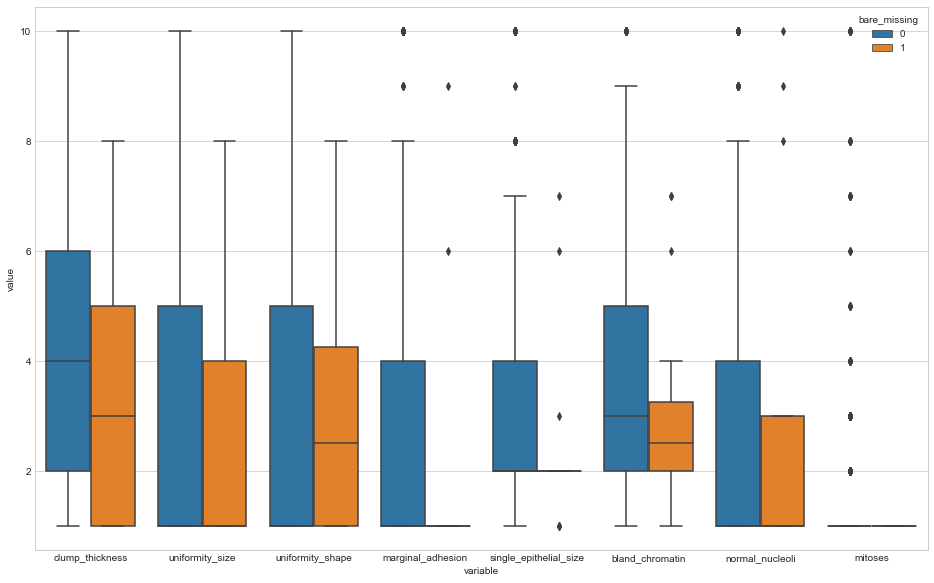

In [13]:
# Look at the distribution of other information for missing and non-missing values;
# First, convert to long format for plotting by missing values indicator
data['bare_missing'] = np.where(data.bare_nuclei == '?', 1, 0)
long = pd.melt(data, id_vars=['sample_id', 'bare_missing'], value_vars=['clump_thickness', 'uniformity_size', 'uniformity_shape',
                'marginal_adhesion', 'single_epithelial_size', 'bland_chromatin',
                'normal_nucleoli', 'mitoses'])
long.value = pd.to_numeric(long.value)

# Make plot
sns.set_style('whitegrid')
sns.boxplot(x='variable', y='value', hue='bare_missing', data=long)
fig = plt.gcf()
fig.set_size_inches( 16, 10)

There is much less data for missing values than for non-missing values, so the distributional information won't be as informative, but looking at the data will at least give us some information as to whether there are hugely systematic differences between the missing and non-missing values (i.e., how random is the missing data).

A quick look tells me that there might be some differences in the distribution of marginal_adhesion and single_epithelial_size between missing and non-missing values.

Let's look at some scatterplots for non-missing values for the features to see if there might be information there that could help us impute bare_nuclei from them, or if we should consider deleting these observations, or using other imputation strategies like median or mode.

In [14]:
non_missing = data[data.bare_nuclei != '?']
non_missing.drop(['bare_missing', 'sample_id'], axis = 1, inplace=True)
non_missing['bare_nuclei'] = pd.to_numeric(non_missing.bare_nuclei)

/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


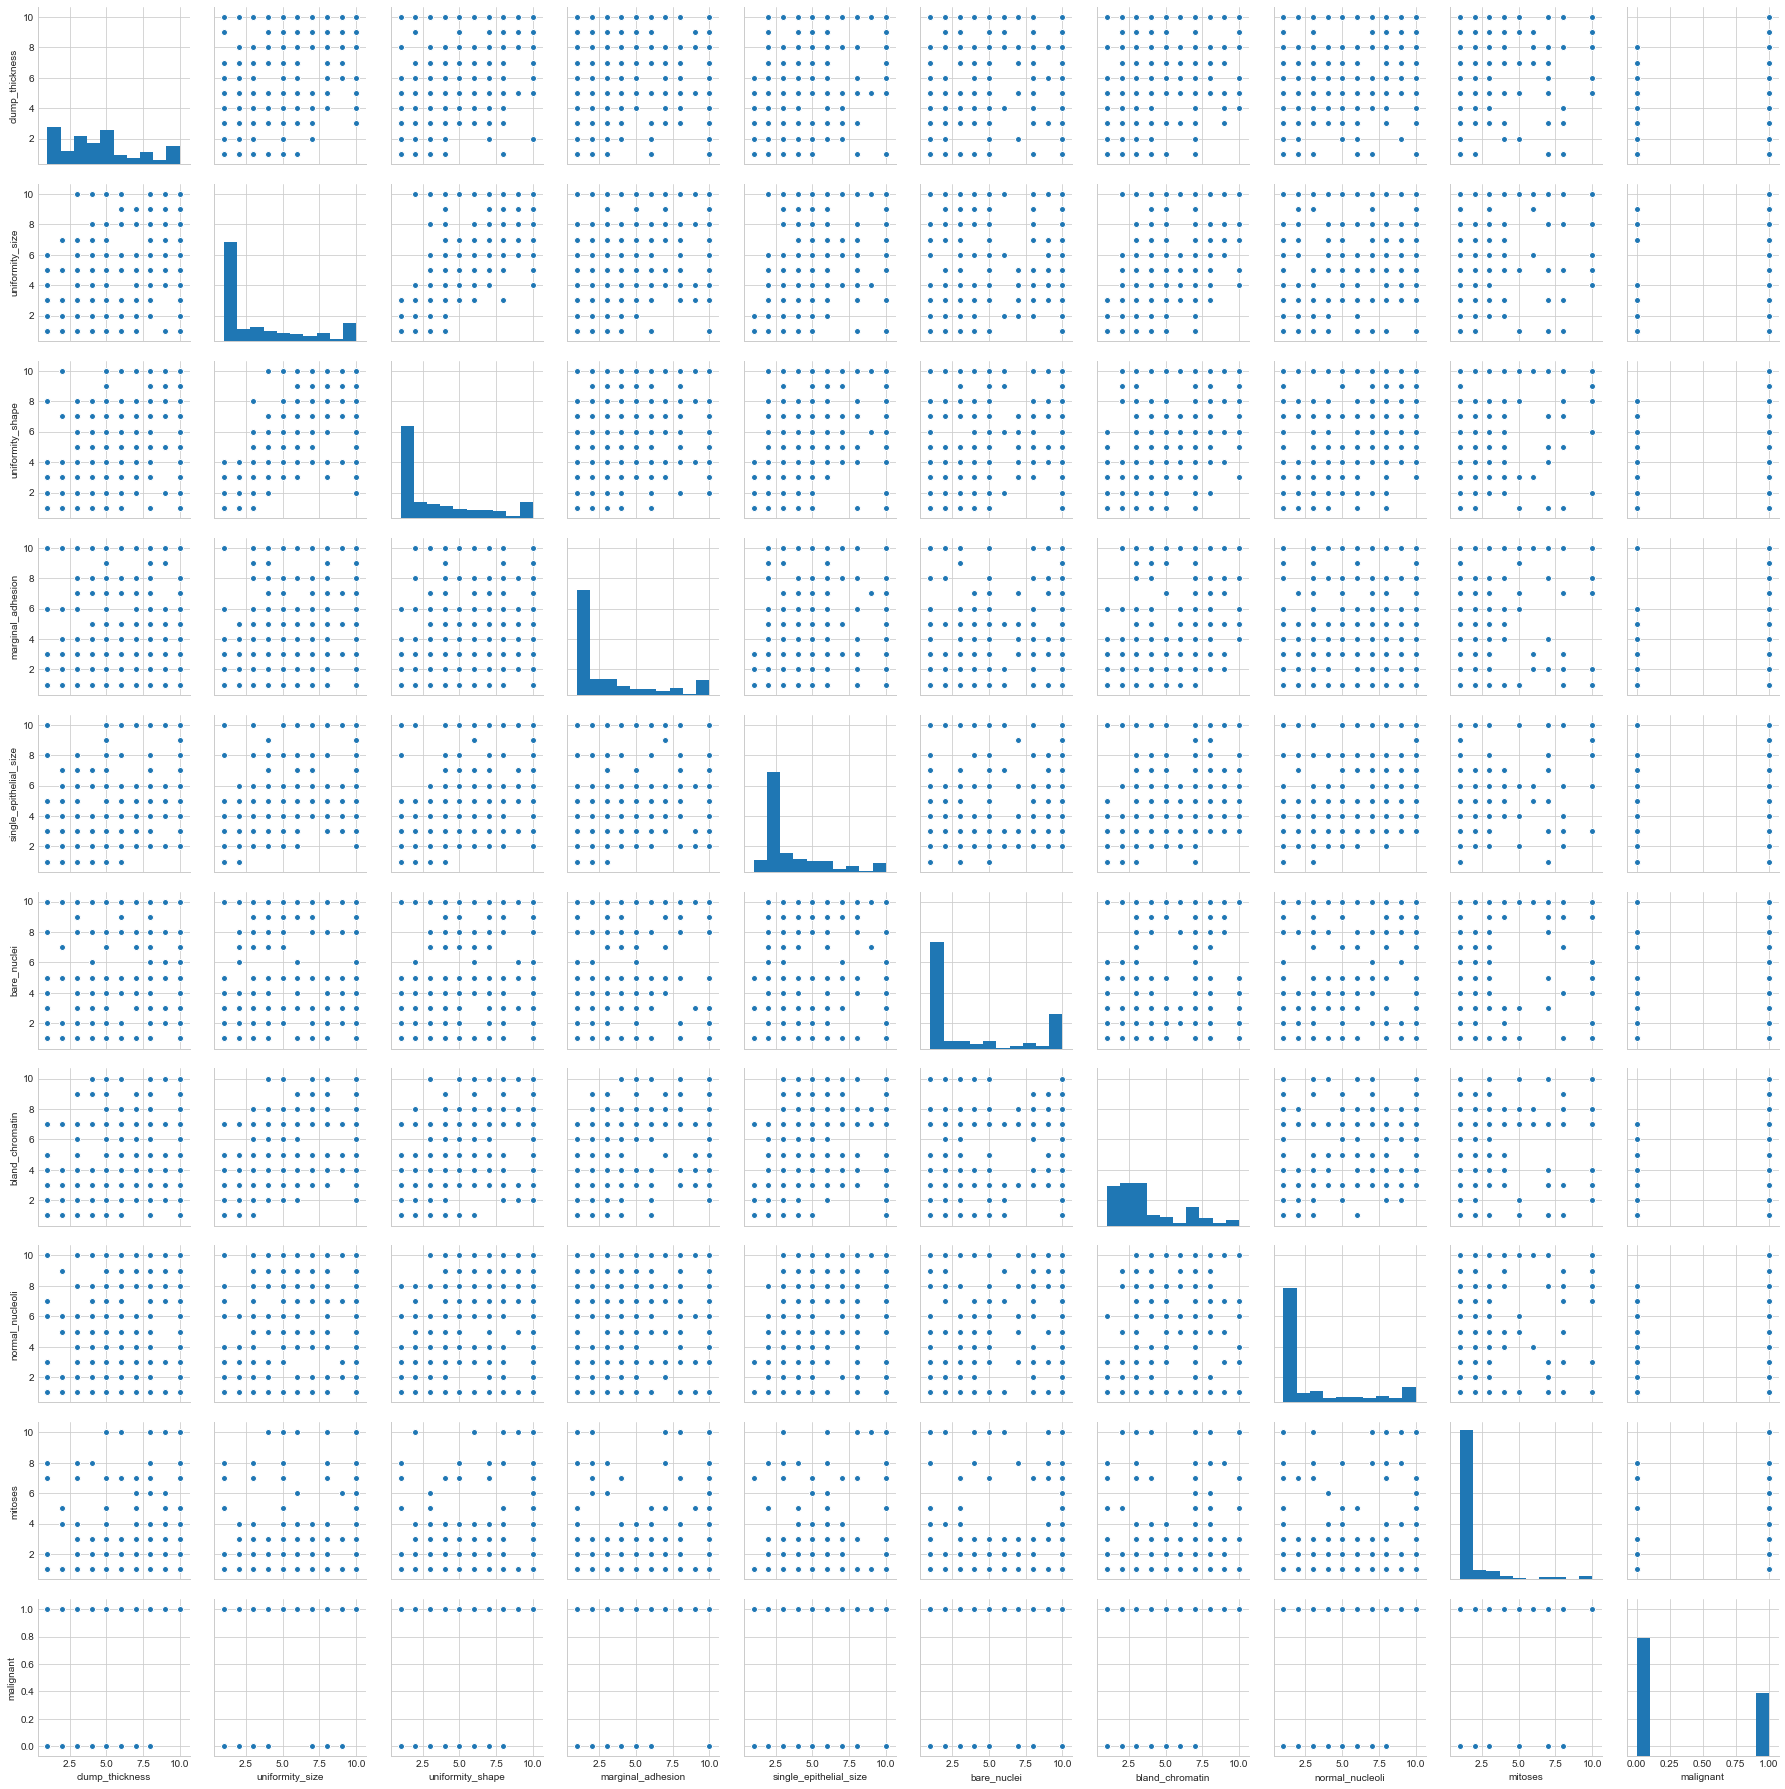

In [14]:
sns.pairplot(non_missing)

Unfortunatley this plot isn't terribly informative for whether bare_nuclei correlates with any of the other variables. This is a consequence of the nature of the data (integer values between 1 and 10, so a restricted range of possible values). The scatterplots necessarily therefore overplot lots of data. 

The histogram of bare_nuclei is informative, though, in that it is apparent that the variable is bi-modally distributed. Values show a mode at 1, with a second mode at 10.

Since the scatterplots on their own aren't very informative about correlations between bare_nuclei and the other variables, let's look at a correlation matrix.

In [15]:
non_missing.corr()

,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
clump_thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957,0.714790
uniformity_size,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755,0.820801
uniformity_shape,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258,0.821891
marginal_adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898,0.706294
single_epithelial_size,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583,0.690958
bare_nuclei,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210,0.822696
bland_chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011,0.758228
normal_nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757,0.718677
mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000,0.423448
malignant,0.714790,0.820801,0.821891,0.706294,0.690958,0.822696,0.758228,0.718677,0.423448,1.000000


bare_nuclei does show good (moderate to high-moderate) correlations with other variables (even when excluding the high correlation with malignant), meaning that we would have a basis for imputation using other known variables.

Before I do this, let's look more closely at bare_nuclei's relationship with malignancy.

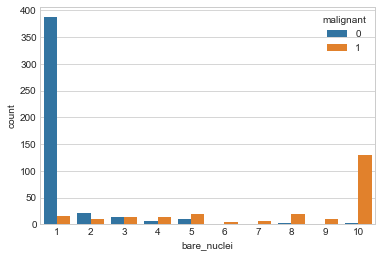

In [16]:
sns.countplot(x = 'bare_nuclei', hue = 'malignant', data = non_missing)

This is very informative.  The 1 (and other low) values of bare_nuclei are overwhelmingly benign, and the 10 (and other high) values of bare_nuclei are overwhelmingly malignant. This indicates that bare_nuclei is a very important feature for predicting malignancy.

Are there other important features for predicting malignancy? Let's look.

/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


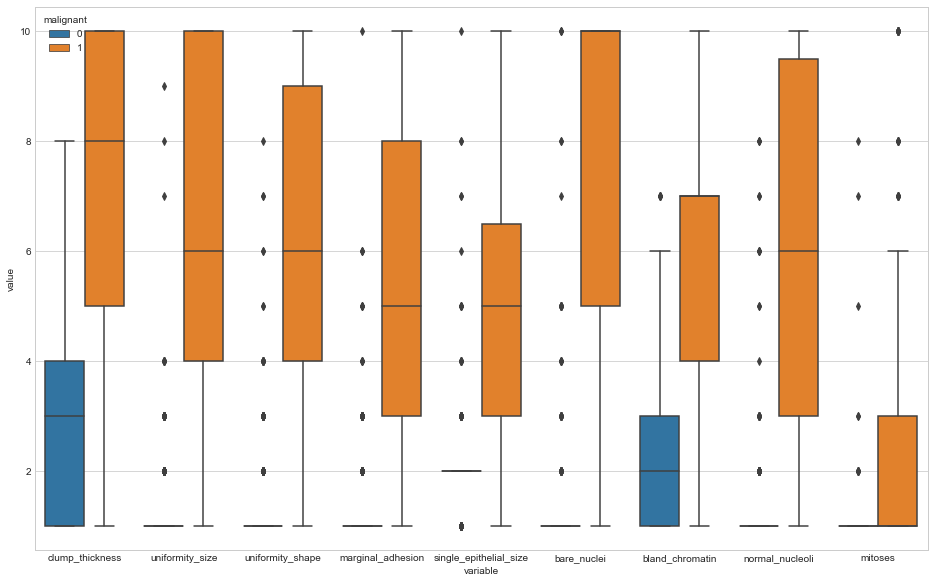

In [17]:
non_missing_long = pd.melt(non_missing, id_vars=['sample_id', 'malignant'], value_vars=['clump_thickness', 'uniformity_size', 'uniformity_shape',
                'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei', 'bland_chromatin',
                'normal_nucleoli', 'mitoses'])
sns.boxplot(x='variable', y='value', hue='malignant', data=non_missing_long)
fig = plt.gcf()
fig.set_size_inches( 16, 10)

All of the variables seem potentially informative. Either the means of the variables are different, the variances different, or both, between the benign and malignant samples. 

Let's impute using linear regression.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [19]:
# Re-get matrices for missing and non-missing data, leaving off malignancy and id columns
missing = data[data.bare_nuclei == '?']
missing.drop(['sample_id', 'malignant', 'bare_missing', 'bare_nuclei'], axis = 1, inplace=True)

non_missing = data[data.bare_nuclei != '?']
non_missing.drop(['sample_id', 'malignant', 'bare_missing'], axis = 1, inplace=True)

# Set aside this vector for prediction
y = pd.to_numeric(non_missing.bare_nuclei)

non_missing.drop(['bare_nuclei'], axis = 1, inplace=True)

/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [20]:
# Create and fit data scaler; scale missing and non-missing data using the same scaler fit to the non-missing data
scaler = StandardScaler()
non_missing_std = scaler.fit_transform(non_missing)
missing_std = scaler.transform(missing)

In [21]:
# Fit linear regression to non-missing standardized data, then predict bare_nuclei for missing data
reg = LinearRegression().fit(non_missing_std, y)
pred = reg.predict(non_missing_std)
r2_score(y, pred) # Decent, but not overwhelming fit, but we'll go with it

# predict bare_nuclei for missing data
bare_nuclei_missing = reg.predict(missing_std)

In [22]:
# Put data back together, with imputed bare_nuclei values
missing = data[data.bare_nuclei == '?']
missing.drop(['sample_id', 'bare_missing'], axis = 1, inplace=True)
missing['bare_nuclei'] = bare_nuclei_missing

non_missing = data[data.bare_nuclei != '?']
non_missing.drop(['sample_id', 'bare_missing'], axis = 1, inplace=True)

/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
new_data = pd.concat([missing, non_missing])

### Fit models

#### Split into test and training data

In [24]:
from sklearn.model_selection import train_test_split

X = new_data.drop('malignant', axis=1)
y = new_data.malignant


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

#### Create random forest cross-validator

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
classifier = RandomForestClassifier(oob_score=True, random_state=100)

In [132]:
grid = GridSearchCV(estimator=classifier,
                    cv = 5,
                    scoring = 'recall',
                    param_grid = {
                        'n_estimators': [100, 500, 1000],
                        'max_features': [2, 3, 4],
                        'max_depth': [None, 3, ],
                        'class_weight': ['balanced', None]
                   })

In [133]:
# Run the cross-validation
cv_results = grid.fit(X_train, y_train)

In [134]:
cv_results.best_params_

{'class_weight': 'balanced',
 'max_depth': 3,
 'max_features': 2,
 'n_estimators': 100}

#### Fit model with best parameters

In [135]:
classifier = RandomForestClassifier(oob_score=True, random_state=100, class_weight='balanced', max_depth=3,
                                   max_features = 2, n_estimators = 100)

In [157]:
model = classifier.fit(X_train, y_train)
model.feature_importances_

array([0.04116419, 0.19543985, 0.23450734, 0.07819416, 0.12728325,
       0.19176199, 0.06786938, 0.05922427, 0.00455556])

In [162]:
feature_importances = pd.DataFrame({'Importance': model.feature_importances_,
                                  'Features': X_train.columns})
feature_importances # uniformity is most important. Plot this versus malignancy

,Importance,Features
0,0.041164,clump_thickness
1,0.195440,uniformity_size
2,0.234507,uniformity_shape
3,0.078194,marginal_adhesion
4,0.127283,single_epithelial_size
5,0.191762,bare_nuclei
6,0.067869,bland_chromatin
7,0.059224,normal_nucleoli
8,0.004556,mitoses


#### Apply this model to the test data

In [148]:
test_preds = model.predict(X_test)

In [153]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

In [151]:
print(classification_report(y_test, test_preds))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       138
          1       0.95      0.99      0.97        72

avg / total       0.98      0.98      0.98       210



In [156]:
print(confusion_matrix(y_test, test_preds))

[[134   4]
 [  1  71]]


Overall, this model is very accurate.  After cross-validation to select the best parameters for the random forest model, applying this model to predict malignancy in the test data showed very good results. Prcision and recall for the benign class was excellent, and recall for the malignant class was excellent; precision was not quite as strong, but still very good at .95. 

When building the CV search, I asked the model to use recall as the scoring metric. I chose this because for cancer, we want to make sure we have as few false negatives as possible. The recall score for the test data showed that we achieved this goal. The confusion matrix shows that the model only gives us one false negative out of 72 malignancies; there were four false positives out of 138 benign samples.

When looking at the most important features for predicting malignancy, the most important was uniformity of shape, followed closely by uniformity of size and bare nuclei. When looking at the set of boxplots above, we can see that malignant tumors have higher values for these features and more variable values than benign tumors.